This notebook aims to discuss different methods of estimating lightning NOx production efficiency (PE).

## Method 1: time series

Because the TROPOMI passes over the Arctic convection for multiple times, we can use that to calculate the PE and lifetime ($\tau$).

$LNO_{2_{T1}}$ * $A_{T1}$ = $LNO_{2_{T0}}$ * $A_{T0}$ * $e^\frac{{-(T_1-T_0)}}{\tau}$ + $PE$ * $\sum_{i=1}^{m} e^\frac{{-(t_i-T_0)}}{\tau}$

$LNO_{2_{T2}}$ * $A_{T2}$ = $LNO_{2_{T1}}$ * $A_{T1}$ * $e^\frac{{-(T_2-T_1)}}{\tau}$ + $PE$ * $\sum_{j=1}^{n} e^\frac{{-(t_j-T_1)}}{\tau}$

<!-- = $LNO_{2_{T0}}$ $e^\frac{{-(T_2-T_0)}}{\tau}$ + $\sum_{i=1}^{m} LNO_{2_{t_i}} e^\frac{{-(t_i-T_0+T_2-T_1)}}{\tau}$ + $\sum_{j=1}^{n} LNO_{2_{t_j}} e^\frac{{-(t_j-T_1)}}{\tau}$ -->


where $T_{<num>}$ is the TROPOMI overpass time,
$LNO_{2_{T<num>}}$ is the $LNO_2$ above cloud in the mask,
$A_{T<num>}$ is the area (m2) of $LNO_{2_{T<num>}}$ pixel,
$t_{<num>}$ is the lightning occuring time in the mask,
$LNO_{2_{t<num>}}$ is the produced $LNO_2$ by each flash which is called production efficiency (PE),
and $\tau$ is the $NO_2$ lifetime.

If we assume the PE is constant in the period, then there're only two unknown number (PE and $\tau$) for two equations.

In other words, the three consecutive orbits are useful for estimating the mean PE and $\tau$ from $T_0$ to $T_1$, which can be represented by local time or solar zenith angle.

### Pros

- Lifetime and PE can be derived at the same time

### Cons

- Smaller SZA leads to larger NO2 VCD. So, there are other NO2 production sources and the $\tau$ may be not actually constant.

- assumption: the cloud is still at the similar level, otherwise the above-cloud NO2 will depends on cloud top height. But, maybe when the cloud is higher, there're some clouds are lower ...

- the PE is the LNO2 PE above cloud


## Method 2: cloud slicing

![cloud slicing](./imgs/Choi_2014.png)

### Prons

- the mean mixing ratio between the highest and lowest upper tropospheric cloud can be derived

### Cons

- the regression is poor

- estimatino of lifetime sounds impossible because of the high regression slope uncertainty

- only works several hours after convection initiation when there're clouds of different levels

- we need to subtract the background NO2 first and then apply cloud slicing

- the mean mixing ratio is the mean upper tropospheric LNO2 mixing ratio

- assumption: the sum of NO2 can stand for the integration of NO2 profile --> LNO2 mixing ratio above cloud

- To get the LNO2 or LNOx PE, we need to apply the lifetime ...

- the NO2 mean mixing ratio needs to be converted into NOx mixing ratio and profile. Note that the NO2:NOx is only well known for ~ 13:30 LT.

## Method 1 example

In [1]:
import xarray as xr
from glob import glob
import numpy as np
import pandas as pd
import proplot as pplt
from distfit import distfit
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve
from scipy.optimize import fsolve
from matplotlib.ticker import PercentFormatter

import sys
sys.path.append("../scripts")
from s5p_lnox_amf import cal_bamf, cal_amf, cal_tropo

In [2]:
lut_pattern = glob('../data/tropomi/S5P_OPER_LUT_NO2AMF*')
lut = xr.open_mfdataset(lut_pattern, combine='by_coords')

In [3]:
def calc_vars(ds):
    ds['amf_geo'] = 1/np.cos(np.radians(ds['solar_zenith_angle'])) + 1/np.cos(np.radians(ds['viewing_zenith_angle']))

    ds['SCD_Strato'] = ds['nitrogendioxide_stratospheric_column'] * ds['air_mass_factor_stratosphere']
    ds['SCD_Trop'] = ds['nitrogendioxide_slant_column_density'] - ds['SCD_Strato']

    ds['SCD_Strato'] = ds['SCD_Strato'].rename('SCD_Strato')
    ds['SCD_Trop'] = ds['SCD_Trop'].rename('SCD_Trop')
    ds['SCD_Strato'].attrs['units'] = 'mol m-2'
    ds['SCD_Trop'].attrs['units'] = 'mol m-2'

    # calculate pressure levels
    a = ds['tm5_constant_a']
    b = ds['tm5_constant_b']
    psfc = ds['surface_pressure']

    low_p = (a[:, 0] + b[:, 0]*psfc)/1e2
    high_p = (a[:, 1] + b[:, 1]*psfc)/1e2

    ds['bot_p'] = low_p
    ds['top_p'] = high_p

    itropo = ds['tm5_tropopause_layer_index']
    itropo.attrs['_FillValue'] = int(9.96921e36)

    ds['ptropo'] = cal_tropo(ds['bot_p'], itropo)


def read_file(filename):
    # filename = glob('../data/clean_lightning/S5P_PAL__L2__NO2____20190811T02*020301.nc')[0]
    ds_tropomi = xr.open_dataset(filename, group='S5P').isel(time=0)
    ds_lightning = xr.open_dataset(filename, group='Lightning')

    # get the label of lightning mask except 0, which is no-lightning data
    mask_labels = np.unique(ds_tropomi['lightning_mask'])[1:]

    # pick one for example
    region_mask = ds_tropomi['lightning_mask'] == mask_labels[0]

    # we can get the x and y limits for a larger region, in case the mask is not enough
    #   or we need to apply segmentation or transform which doesn't allow nan value
    xy_mask = region_mask.assign_coords({'x': range(region_mask.sizes['x']), 'y': range(region_mask.sizes['y'])}).where(region_mask>0, drop=True)

    xlim = (xy_mask['x'].min().values, xy_mask['x'].max().values)
    ylim = (xy_mask['y'].min().values, xy_mask['y'].max().values)

    ds_mask = ds_tropomi.isel(x=slice(xlim[0], xlim[1]), y=slice(ylim[0], ylim[1]))
    # update the delta
    t_overpass = pd.to_datetime(ds_mask['time_utc']).mean()

    calc_vars(ds_mask)

    s5p_origin, bAmfClr, bAmfCld, del_lut = cal_bamf(ds_mask, lut)

    ds_amf = cal_amf(ds_mask, s5p_origin,
                xr.merge([ds_mask['no2_vmr'].rename('no2'), ds_mask['temperature'].rename('tk')]),
                bAmfClr, bAmfCld)

    no2_vis = ds_mask['SCD_Trop'] / ds_amf['amfTropVis']  # ds_amf['no2TropVis']
    no2_vis_geo = ds_mask['SCD_Trop']/ds_mask['amf_geo']

    no2_vis.load(), no2_vis_geo.load()

    # smooth data with a Gaussian kernel with x_stddev=0.5 and y_stddev=0.5
    # It is a 9x9 array
    # https://docs.astropy.org/en/stable/convolution/index.html
    kernel = Gaussian2DKernel(0.5, 0.5)

    no2_vis_conv = convolve(no2_vis, kernel)

    # Initialize model
    dist = distfit(distr='lognorm', alpha=0.1)

    # Find best theoretical distribution for empirical data X
    dist.fit_transform(no2_vis_conv.ravel()[~np.isnan(no2_vis_conv.ravel())], verbose=0)

    no2_vis_mask = np.ma.masked_array(no2_vis, no2_vis_conv<dist.model['CII_max_alpha'])

    lno2_vis = no2_vis_mask - dist.model['CII_max_alpha']

    lno2_vis = xr.DataArray(lno2_vis, dims=['y', 'x']).assign_coords(longitude=ds_mask['longitude'])

    return ds_mask['apparent_scene_pressure']/100, lno2_vis, t_overpass, ds_lightning

def func(x, lno2_vis_t0, lno2_vis_t1, lno2_vis_t2,
         overpass_t0, overpass_t1, overpass_t2,
         ds_lightning_t1, ds_lightning_t2):
    tau = x[0]
    pe = x[1]
    area = 5.6*3.6*1e6 # 5.6*3.6 km2 (after 2019/08/06) or 7.2*3.6 km2 (before)
    f1 = np.nansum(lno2_vis_t1) * area - \
         np.nansum(lno2_vis_t0) * area * np.exp(-(overpass_t1 - overpass_t0).total_seconds()/3600/tau) - \
         pe * np.exp(-ds_lightning_t1['delta']/tau).sum() * 4
    f2 = np.nansum(lno2_vis_t2) * area - \
         np.nansum(lno2_vis_t1) * area * np.exp(-(overpass_t2 - overpass_t1).total_seconds()/3600/tau) - pe * np.exp(-ds_lightning_t2['delta']/tau).sum() * 4

    return [f1, f2]

In [4]:
def consecutive_orbits(date0, date1, date2):
    base_dir = '../data/clean_lightning/S5P_PAL__L2__NO2____'

    filename = glob(base_dir+date0+'*.nc')[0]
    cp_t0, lno2_vis_t0, overpass_t0, ds_lightning_t0 = read_file(filename)

    filename = glob(base_dir+date1+'*.nc')[0]
    cp_t1, lno2_vis_t1, overpass_t1, ds_lightning_t1 = read_file(filename)
    # calculate the delta (hour) between lightning and previous TROPOMI overpass time
    ds_lightning_t1['delta'][:] = (ds_lightning_t1['time'] - overpass_t0.to_datetime64()) / np.timedelta64(1, 'h')
    ds_lightning_t1 = ds_lightning_t1.where(ds_lightning_t1['delta'] > 0, drop=True)

    filename = glob(base_dir+date2+'*.nc')[0]
    cp_t2, lno2_vis_t2, overpass_t2, ds_lightning_t2 = read_file(filename)
    # calculate the delta (hour) between lightning and previous TROPOMI overpass time
    ds_lightning_t2['delta'][:] = (ds_lightning_t2['time'] - overpass_t1.to_datetime64()) / np.timedelta64(1, 'h')
    ds_lightning_t2 = ds_lightning_t2.where(ds_lightning_t2['delta'] > 0, drop=True)

    root = fsolve(func, [3, 300],
                args=(lno2_vis_t0, lno2_vis_t1, lno2_vis_t2,
                        overpass_t0, overpass_t1, overpass_t2,
                        ds_lightning_t1, ds_lightning_t2))

    tau = root[0]; pe = root[1]

    return tau, pe, cp_t0, cp_t1, cp_t2, lno2_vis_t0, lno2_vis_t1, lno2_vis_t2, overpass_t0, overpass_t1, overpass_t2

In [5]:
def plot_res(tau, pe, lno2_vis_t0, lno2_vis_t1, lno2_vis_t2, cp_t0, cp_t1, cp_t2):
    fig, axs = pplt.subplots(nrows=2, ncols=2, share=0)

    vmin = 0
    vmax = np.max([lno2_vis_t0.max(), lno2_vis_t1.max(), lno2_vis_t2.max()])

    xmin = np.min([lno2_vis_t0.longitude.min(), lno2_vis_t1.longitude.min(), lno2_vis_t2.longitude.min()])
    xmax = np.max([lno2_vis_t0.longitude.max(), lno2_vis_t1.longitude.max(), lno2_vis_t2.longitude.max()])
    ymin = np.min([lno2_vis_t0.latitude.min(), lno2_vis_t1.latitude.min(), lno2_vis_t2.latitude.min()])
    ymax = np.max([lno2_vis_t0.latitude.max(), lno2_vis_t1.latitude.max(), lno2_vis_t2.latitude.max()])

    # plot LNO2Vis
    lno2_vis_t0.plot(ax=axs[0], discrete=False, vmin=vmin, vmax=vmax, x='longitude', y='latitude')
    lno2_vis_t1.plot(ax=axs[1], discrete=False, vmin=vmin, vmax=vmax, x='longitude', y='latitude')
    lno2_vis_t2.plot(ax=axs[2], discrete=False, vmin=vmin, vmax=vmax, x='longitude', y='latitude')

    axs[:3].format(xlabel='', ylabel='', xformatter='deglon', yformatter='deglat',
                xlim=(xmin, xmax), ylim=(ymin, ymax))

    # plot the cloud pressure distribution
    ax = axs[3]
    cp_t0_valid = cp_t0.stack(z=['y','x']).dropna(dim='z')
    cp_t0_valid.plot.hist(ax=ax, bins=np.arange(150, 1025, 25), weights=np.ones(len(cp_t0_valid)) / len(cp_t0_valid),
                        facecolor='none', edgecolor='blue6', edgewidth=1)

    cp_t1_valid = cp_t1.stack(z=['y','x']).dropna(dim='z')
    cp_t1_valid.plot.hist(ax=ax, bins=np.arange(150, 1025, 25), weights=np.ones(len(cp_t1_valid)) / len(cp_t1_valid),
                        facecolor='none', edgecolor='orange6', edgewidth=1, legend='ul')

    cp_t2_valid = cp_t2.stack(z=['y','x']).dropna(dim='z')
    cp_t2_valid.plot.hist(ax=ax, bins=np.arange(150, 1025, 25), weights=np.ones(len(cp_t2_valid)) / len(cp_t2_valid),
                        facecolor='none', edgecolor='violet6')

    ax.yaxis.set_major_formatter(PercentFormatter(1))
    ax.format(xlabel='Apparent Scene Pressure (hPa)', ylabel='Frequency')

    axs.format(title=[overpass_t0.strftime('%Y-%m-%d %H:%M'),
                    overpass_t1.strftime('%Y-%m-%d %H:%M'),
                    overpass_t2.strftime('%Y-%m-%d %H:%M'),
                    ''],
               suptitle=f'Lifetime: {tau} hour, PE: {pe} mol/stroke',
            )

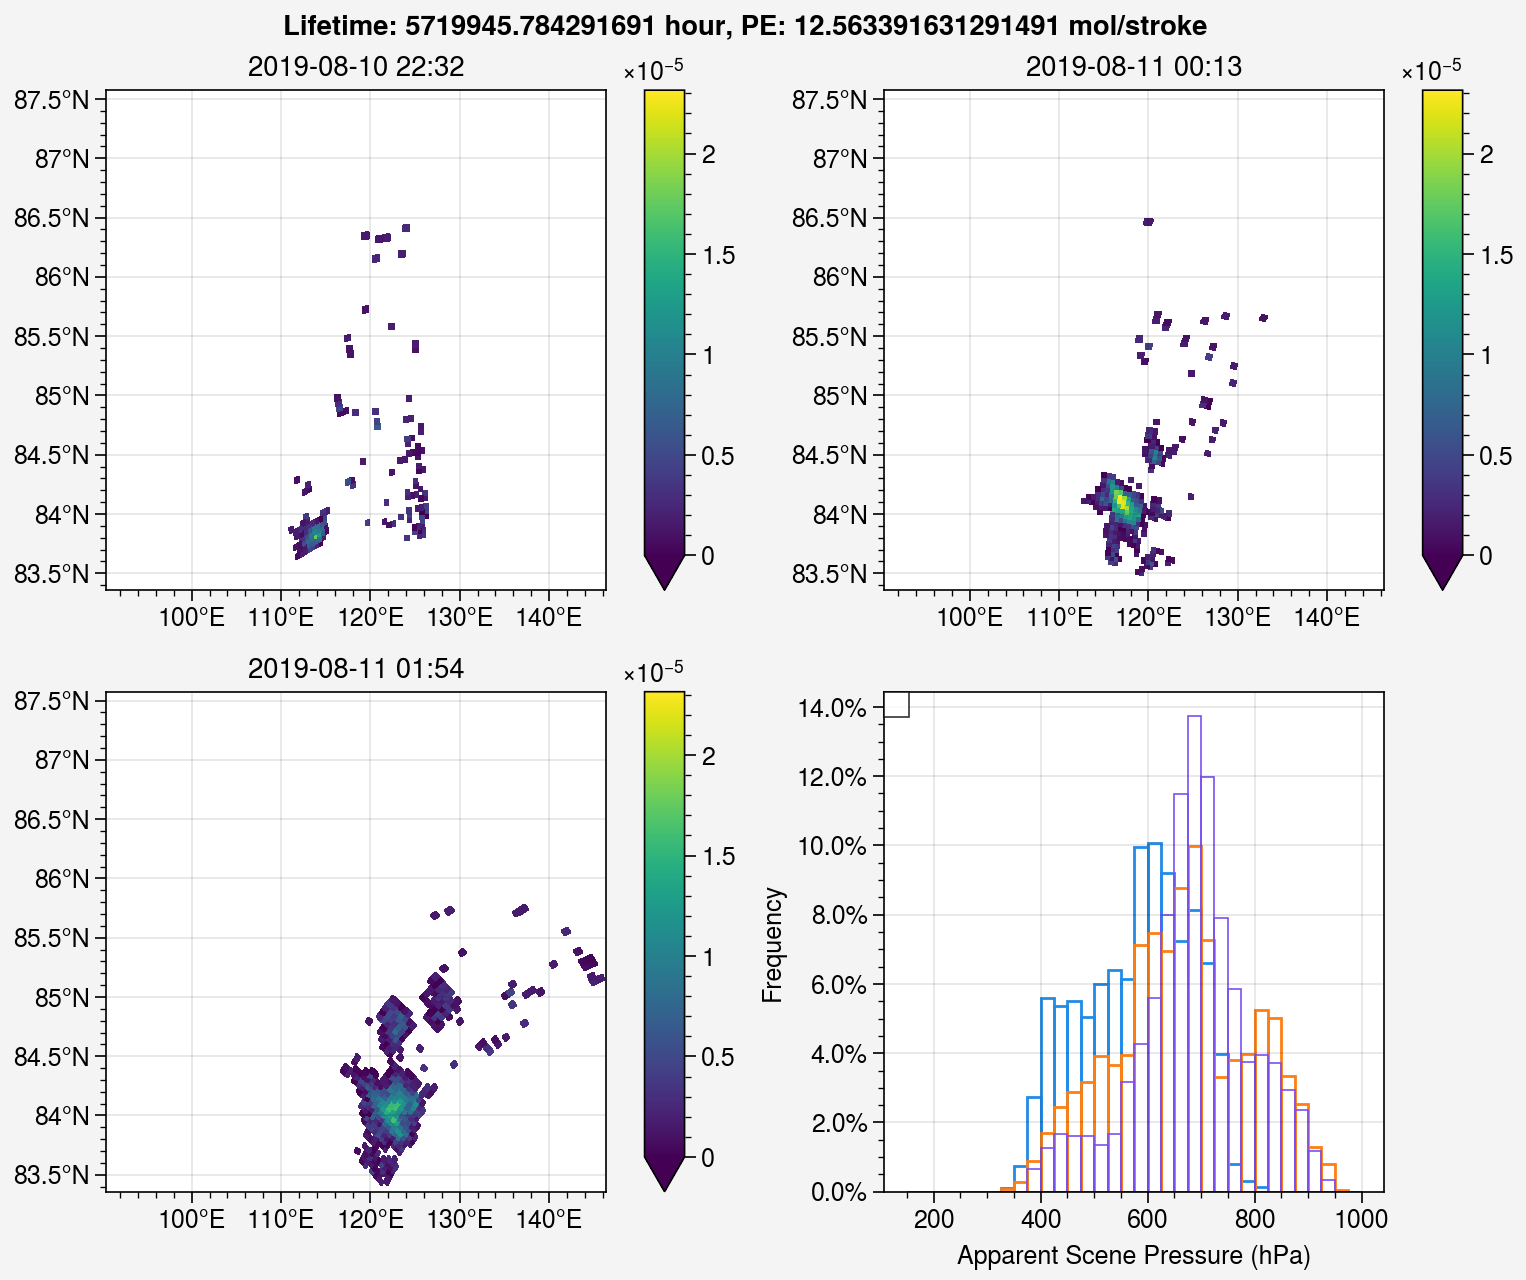

In [6]:
tau, pe, cp_t0, cp_t1, cp_t2, lno2_vis_t0, lno2_vis_t1, lno2_vis_t2, overpass_t0, overpass_t1, overpass_t2 = consecutive_orbits('20190810T21', '20190810T23', '20190811T00')

plot_res(tau, pe, lno2_vis_t0, lno2_vis_t1, lno2_vis_t2, cp_t0, cp_t1, cp_t2)

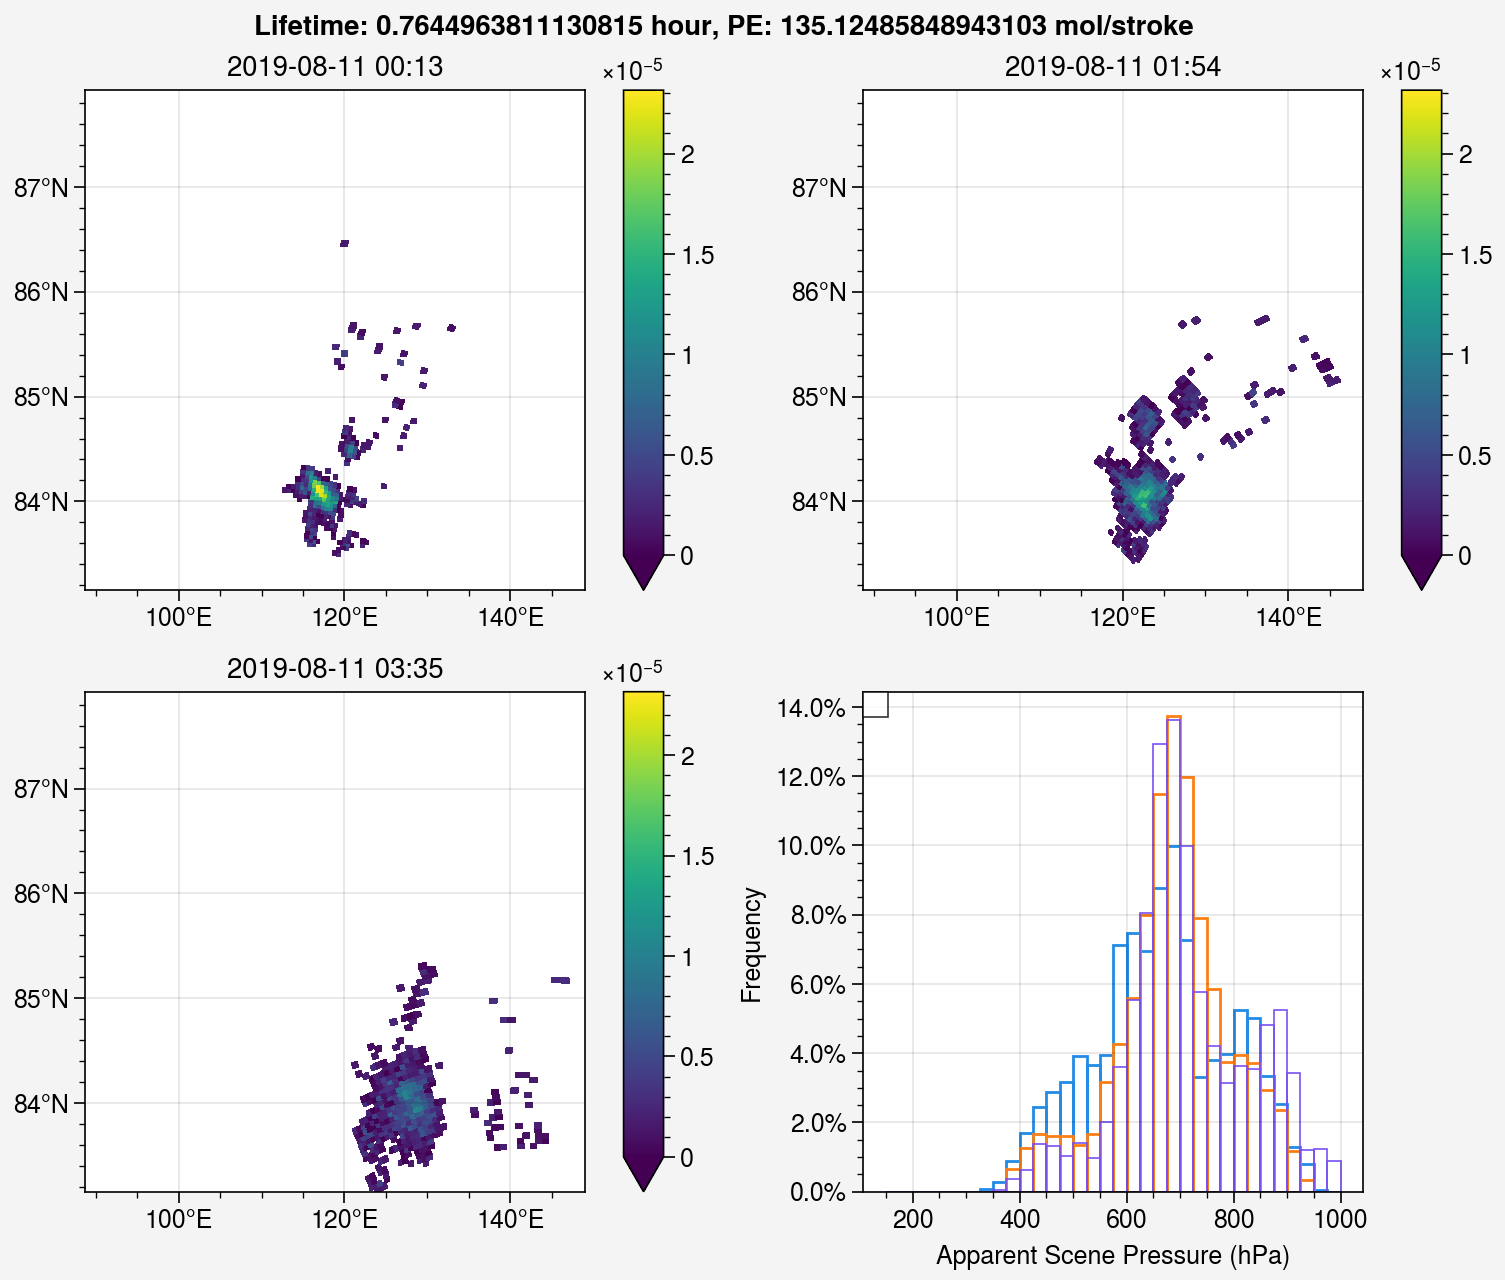

In [7]:
tau, pe, cp_t0, cp_t1, cp_t2, lno2_vis_t0, lno2_vis_t1, lno2_vis_t2, overpass_t0, overpass_t1, overpass_t2 = consecutive_orbits('20190810T23', '20190811T00', '20190811T02')

plot_res(tau, pe, lno2_vis_t0, lno2_vis_t1, lno2_vis_t2, cp_t0, cp_t1, cp_t2)

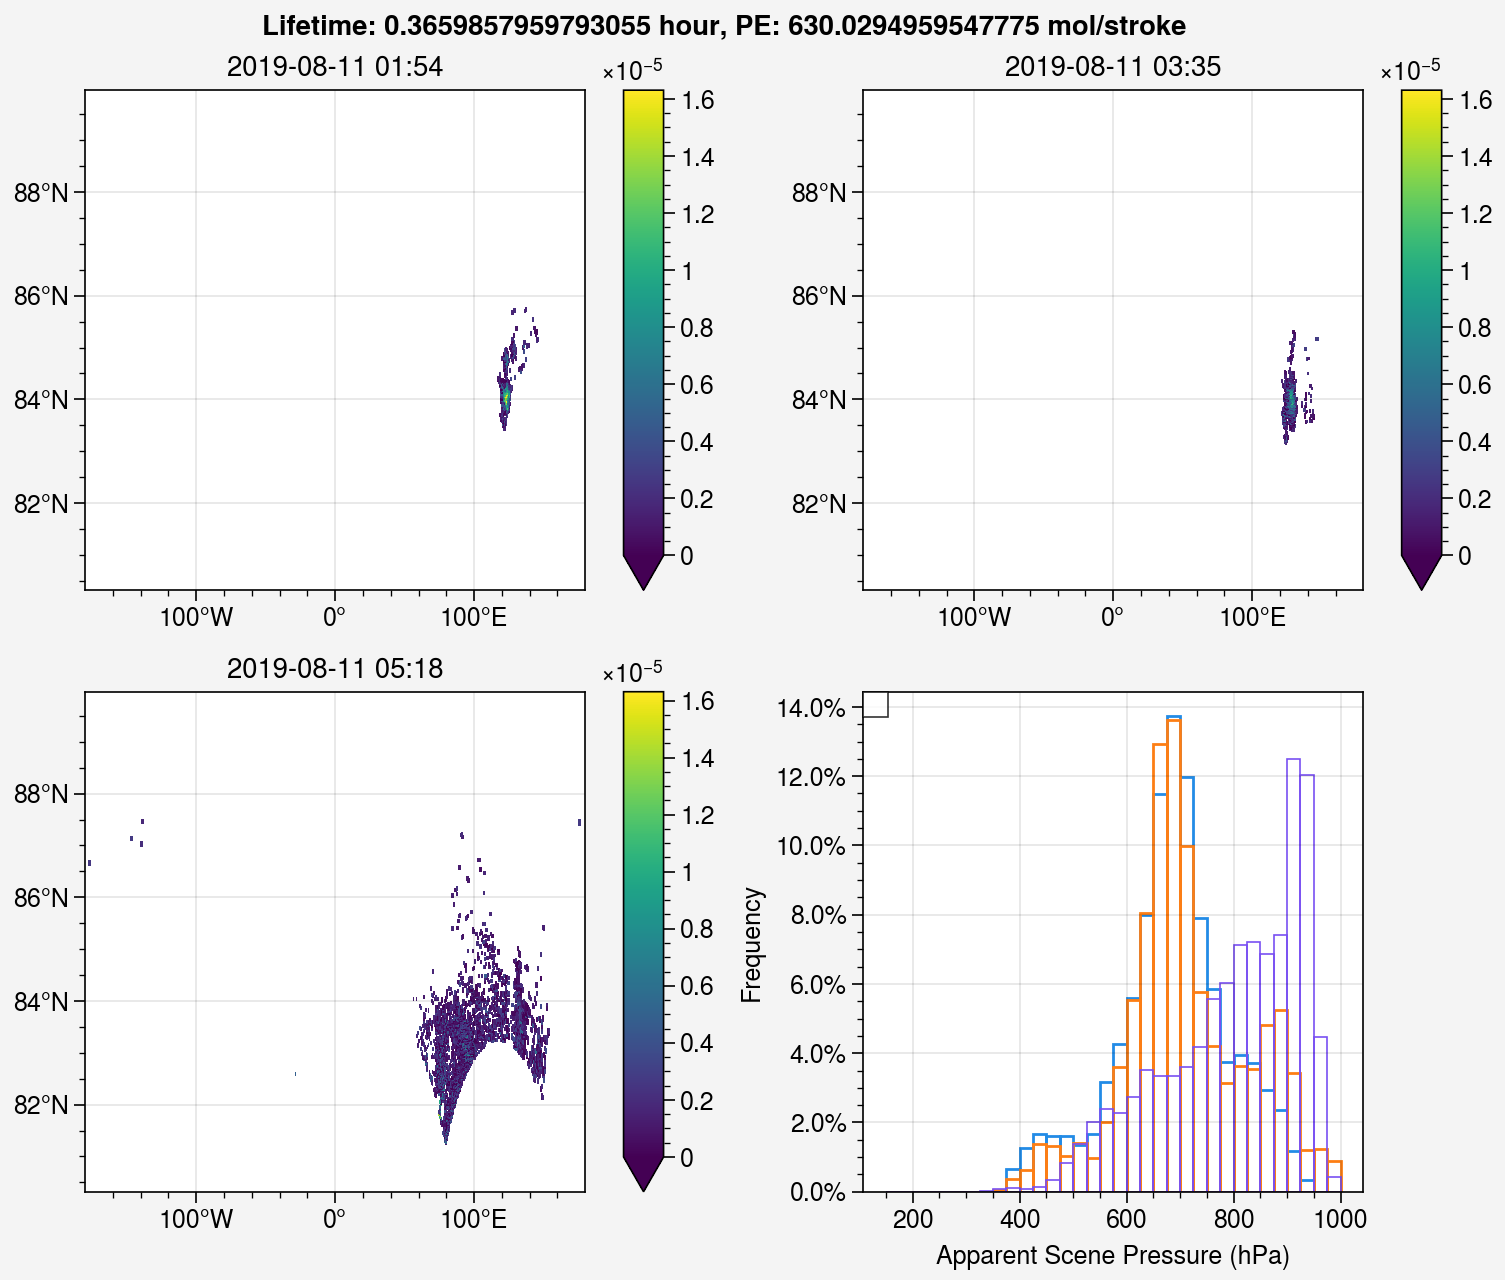

In [8]:
tau, pe, cp_t0, cp_t1, cp_t2, lno2_vis_t0, lno2_vis_t1, lno2_vis_t2, overpass_t0, overpass_t1, overpass_t2 = consecutive_orbits('20190811T00', '20190811T02', '20190811T04')

plot_res(tau, pe, lno2_vis_t0, lno2_vis_t1, lno2_vis_t2, cp_t0, cp_t1, cp_t2)

The first method needs cloud pressure distributions are similar for three consecutive orbits.